In [115]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pandas as pd
from sklearn.mixture import GaussianMixture


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
df = []

for i in tqdm(glob('/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/general/results/*')):
    v = np.load(i)
    j = i[:-4]
    for w,var in enumerate(np.arange(10,55,2.5)):
        df.append(np.concatenate((j.split('/')[-1].split('_'),[var],v[w])))
        
columns = ['architecture','loss','num_classes','degree','factor','type','chance','variance','psnr','psnr std','ssim','ssim std']
df = pd.DataFrame(df,columns=columns)

In [3]:
df = df.replace('nan',0)
df['variance'] = pd.to_numeric(df['variance'])
df['psnr'] = pd.to_numeric(df['psnr'])
df['psnr std'] = pd.to_numeric(df['psnr std'])
df['ssim'] = pd.to_numeric(df['ssim'])
df['ssim std'] = pd.to_numeric(df['ssim std'])
df = df[df['psnr'] > 0]
df

,architecture,loss,num_classes,degree,factor,type,chance,variance,psnr,psnr std,ssim,ssim std
0,decreasing,Hproduct,10,1,0,classic,1,10.0,31.507936,1.578282,0.856892,0.045294
1,decreasing,Hproduct,10,1,0,classic,1,12.5,30.265808,1.445921,0.824235,0.052465
2,decreasing,Hproduct,10,1,0,classic,1,15.0,29.194902,1.422778,0.804859,0.054819
3,decreasing,Hproduct,10,1,0,classic,1,17.5,28.585098,1.444715,0.782385,0.054004
4,decreasing,Hproduct,10,1,0,classic,1,20.0,27.834023,1.374692,0.763934,0.055094
...,...,...,...,...,...,...,...,...,...,...,...,...
388327,splines,psnr,5,6,0,classic,9,42.5,24.303587,1.430074,0.629435,0.051402
388328,splines,psnr,5,6,0,classic,9,45.0,23.954830,1.463100,0.617889,0.056216
388329,splines,psnr,5,6,0,classic,9,47.5,23.638805,1.441240,0.600821,0.054526
388330,splines,psnr,5,6,0,classic,9,50.0,23.354053,1.349713,0.590816,0.055653


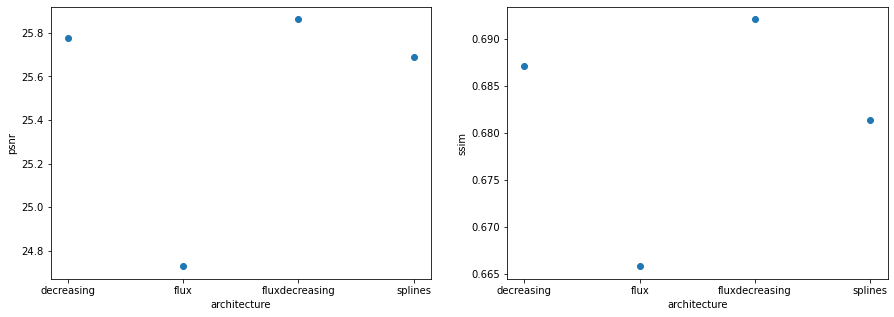

In [4]:
X = df.groupby(['architecture']).mean().reset_index()[['architecture','psnr','ssim']].values.T
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(X[0],X[1])
plt.xlabel('architecture')
plt.ylabel('psnr')
plt.subplot(122)
plt.scatter(X[0],X[2])
plt.xlabel('architecture')
plt.ylabel('ssim')
plt.show()

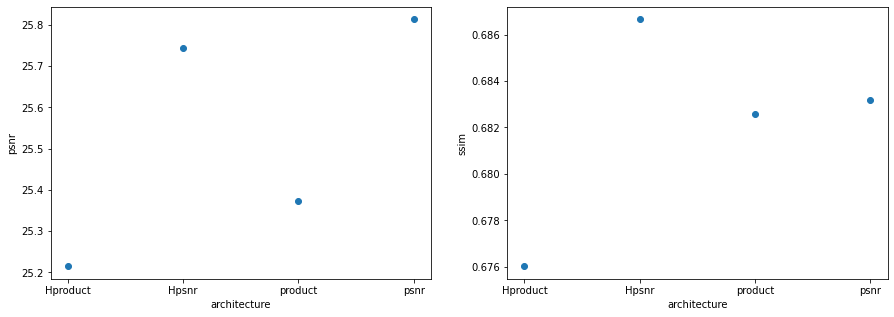

In [5]:
X = df.groupby(['loss']).mean().reset_index()[['loss','psnr','ssim']].values.T
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(X[0],X[1])
plt.xlabel('architecture')
plt.ylabel('psnr')
plt.subplot(122)
plt.scatter(X[0],X[2])
plt.xlabel('architecture')
plt.ylabel('ssim')
plt.show()

In [2]:
def gaussian(frame_num,var=1,CROP = 256):
    input_path = frame_num

    img = np.asarray(cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2GRAY), dtype=np.float32)
    img = cv2.resize(img,(CROP,CROP))
    img = img - np.mean(img)
    gauss = np.random.normal(0,var,img.shape)
    gauss = gauss.reshape(img.shape[0],img.shape[1])
    img_gauss = np.clip(np.copy(img) + gauss- np.amin(img),0,255)
    img_gauss = np.asarray(img_gauss,dtype = np.float32)

    img = img - np.amin(img)
    input_channel = img/np.amax(img)
    img_gauss = np.clip(img_gauss/np.amax(img),0,1)

    return np.array([input_channel, img_gauss])

In [64]:
barbara = [47.86,42.92,37.19,32.83,30.22,28.32,27.04,23.15,21.39,19.77]
boats = [47.69,42.28,36.27,33.05,31.22,29.85,28.72,24.53,22.48,20.80]
house = [48.32,44.01,38.23,35.06,33.48,32.17,31.11,26.74,24.13,21.66]
peppers = [47.81,42.96,37.63,34.28,32.03,30.58,29.20,24.52,21.68,19.60]

foe = [house,peppers,barbara,boats]


variance = [1,2,5,10,15,20,25,50,75,100]
set12_256_l = ['../../images/Set12/02.png','../../images/Set12/03.png']
set12_512_l = ['../../images/Set12/09.png','../../images/Set12/10.png']


set12_256 = np.array([[gaussian(im,var=v,CROP=256) for v in variance] for im in set12_256_l])
ys_256,noisy_256 = set12_256[:,:,0],set12_256[:,:,1]
ys_256,noisy_256 = np.concatenate(ys_256),np.concatenate(noisy_256)
ys_256,noisy_256 = np.expand_dims(ys_256,axis=-1),np.expand_dims(noisy_256,axis=-1)

set12_512 = np.array([[gaussian(im,var=v,CROP=512) for v in variance] for im in set12_512_l])
ys_512,noisy_512 = set12_512[:,:,0],set12_512[:,:,1]
ys_512,noisy_512 = np.concatenate(ys_512),np.concatenate(noisy_512)
ys_512,noisy_512 = np.expand_dims(ys_512,axis=-1),np.expand_dims(noisy_512,axis=-1)

In [10]:
losses_names = ['product','psnr','Hpsnr','Hproduct']
architectures = ['splines','decreasing','flux','fluxdecreasing']
it_lim = 10

df = []



for arch in architectures:

    for loss in losses_names:

        order = 1
        for num_classes in [5,10,15,20,25,50]:

            for degree in np.arange(1,7):
                
                print(arch,loss,num_classes,degree)

                for f1,factor in enumerate([0.001]):

                    for typee in ['classic','noconstraints','nopretrained','diffop','foe','foek']:
                        
                        if len(glob(f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{f1}_{typee}_0*"))==0:
                            continue

                        model_256 = get_model(arch,it_lim=it_lim,image_size=image_size,num_classes = num_classes,
                                                      second=True,degree1=degree,factor=factor,typee=typee)
                        model_256.load_weights(f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{f1}_{typee}_0")


                        model_512 = get_model(arch,it_lim=it_lim,image_size=(512,512),num_classes = num_classes,
                                                      second=True,degree1=degree,factor=factor,typee=typee)
                        model_512.load_weights(f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{f1}_{typee}_0")

                        denoised_256 = model_256(noisy_256)
                        denoised_512 = model_512(noisy_512)

                        psnr_256 = np.array(tf.image.psnr(denoised_256,ys_256,1))
                        psnr_512 = np.array(tf.image.psnr(denoised_512,ys_512,1))
                        h = psnr_256[:len(variance)]
                        p = psnr_256[len(variance):]
                        b = psnr_512[:len(variance)]
                        bo = psnr_512[len(variance):]

                        ih,ip,ib,ibo = h - house,p-peppers,b - barbara, bo - boats

                        for v,var in enumerate(variance):

                            df.append([arch,loss,num_classes,degree,factor,typee,var,ih[v],ip[v],ib[v],ibo[v]])

    


splines product 5 1
splines product 5 2
splines product 5 3
splines product 5 4
splines product 5 5
splines product 5 6
splines product 10 1
splines product 10 2
splines product 10 3
splines product 10 4
splines product 10 5
splines product 10 6
splines product 15 1
splines product 15 2
splines product 15 3
splines product 15 4
splines product 15 5
splines product 15 6
splines product 20 1
splines product 20 2
splines product 20 3
splines product 20 4
splines product 20 5
splines product 20 6
splines product 25 1
splines product 25 2
splines product 25 3
splines product 25 4
splines product 25 5
splines product 25 6
splines product 50 1
splines product 50 2
splines product 50 3
splines product 50 4
splines product 50 5
splines product 50 6
splines psnr 5 1
splines psnr 5 2
splines psnr 5 3
splines psnr 5 4
splines psnr 5 5
splines psnr 5 6
splines psnr 10 1
splines psnr 10 2
splines psnr 10 3
splines psnr 10 4
splines psnr 10 5
splines psnr 10 6
splines psnr 15 1
splines psnr 15 2
spli

flux Hproduct 15 6
flux Hproduct 20 1
flux Hproduct 20 2
flux Hproduct 20 3
flux Hproduct 20 4
flux Hproduct 20 5
flux Hproduct 20 6
flux Hproduct 25 1
flux Hproduct 25 2
flux Hproduct 25 3
flux Hproduct 25 4
flux Hproduct 25 5
flux Hproduct 25 6
flux Hproduct 50 1
flux Hproduct 50 2
flux Hproduct 50 3
flux Hproduct 50 4
flux Hproduct 50 5
flux Hproduct 50 6
fluxdecreasing product 5 1
fluxdecreasing product 5 2
fluxdecreasing product 5 3
fluxdecreasing product 5 4
fluxdecreasing product 5 5
fluxdecreasing product 5 6
fluxdecreasing product 10 1
fluxdecreasing product 10 2
fluxdecreasing product 10 3
fluxdecreasing product 10 4
fluxdecreasing product 10 5
fluxdecreasing product 10 6
fluxdecreasing product 15 1
fluxdecreasing product 15 2
fluxdecreasing product 15 3
fluxdecreasing product 15 4
fluxdecreasing product 15 5
fluxdecreasing product 15 6
fluxdecreasing product 20 1
fluxdecreasing product 20 2
fluxdecreasing product 20 3
fluxdecreasing product 20 4
fluxdecreasing product 20 5
f

In [14]:
columns = ['architecture','loss','num classes','degree','factor','type','variance','house','peppers','barbara','boat']
df = pd.DataFrame(df,columns=columns)
df.to_csv('./vsFoE.csv')

In [61]:
improvements = df.groupby(['architecture','loss','num classes','degree','factor','type']).mean().reset_index()


filters = ['architecture','loss','num classes','degree','type']
pictures = ['house','peppers','barbara','boat']

best = []

for p in pictures:

    best_filters = improvements[improvements[p] == improvements[p].max()][filters].values[0]
    best.append(df[(df['architecture'] == best_filters[0])&(df['loss']==best_filters[1])
  &(df['num classes']==best_filters[2])&(df['degree']==best_filters[3])
  &(df['type']==best_filters[4])])
    

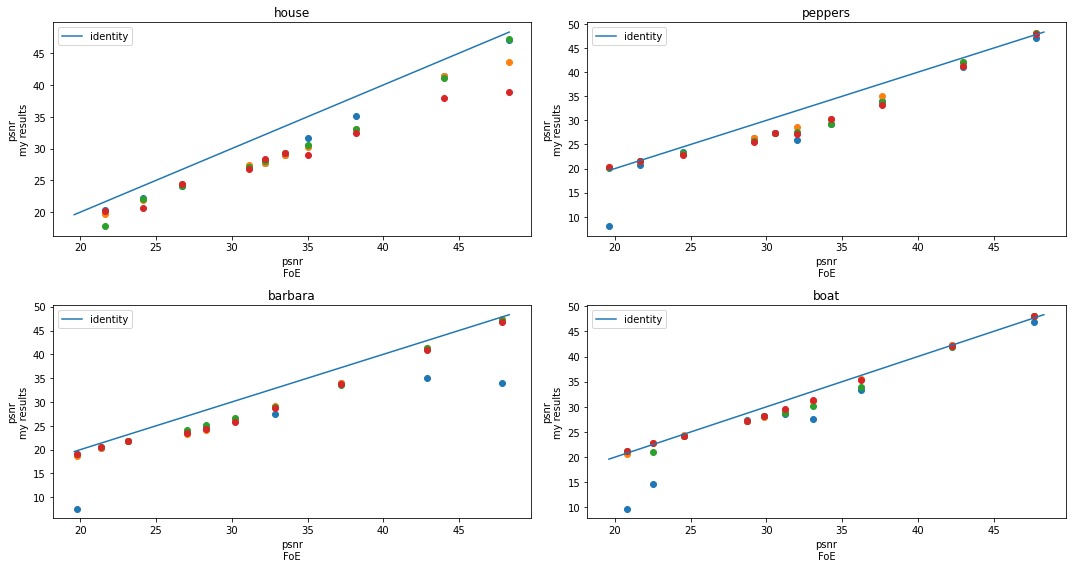

In [78]:
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,8))

for i in range(4):
    for b in range(4):
        axs[i//2,i%2].scatter(foe[i],foe[i]+best[b][pictures[i]].values)
        m,M = np.amin(foe),np.amax(foe)
    axs[i//2,i%2].plot([m,M],[m,M],label='identity')
        
    axs[i//2,i%2].legend()
    axs[i//2,i%2].set_title(pictures[i])
    axs[i//2,i%2].set_xlabel('psnr\nFoE')
    axs[i//2,i%2].set_ylabel('psnr\nmy results')
    
plt.tight_layout()
plt.show()

# Already processed

In [157]:
df = []

for i in tqdm(glob('/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/general/results/*')):
    
    if '_0.npy' not in i:
        continue
    
    v = np.load(i)
    j = i[:-4]
    for w in range(len(v)):
        df.append(np.concatenate((j.split('/')[-1].split('_'),v[w])))

col = ['architecture','loss','num_classes','degree','latent_size','type','known_variance','static_gamma','coco','chance']
        
#columns = ['architecture','loss','num_classes','degree','factor','type','chance','variance','psnr','psnr std','ssim','ssim std']
columns = np.concatenate((col,['variance','house','peppers','barbara','boats']))
df = pd.DataFrame(df,columns=columns)
df = df[(df.house != 'nan')&(df.peppers!='nan')&(df.barbara!='nan')&(df.boats!='nan')]

df.house = pd.to_numeric(df.house)
df.peppers = pd.to_numeric(df.peppers)
df.barbara = pd.to_numeric(df.barbara)
df.boats = pd.to_numeric(df.boats)
df.variance = pd.to_numeric(df.variance)
df.num_classes = pd.to_numeric(df.num_classes)
df.degree = pd.to_numeric(df.degree)
df.latent_size = pd.to_numeric(df.latent_size)
df.known_variance = pd.to_numeric(df.known_variance)
df.static_gamma = pd.to_numeric(df.static_gamma)
df.coco = pd.to_numeric(df.coco)

df = df[(df.house >0)&(df.peppers>0)&(df.barbara>0)&(df.boats>0)]



100%|███████████████████████████████████| 12127/12127 [00:05<00:00, 2289.87it/s]


In [15]:
df.to_csv('./vsFoE.csv')

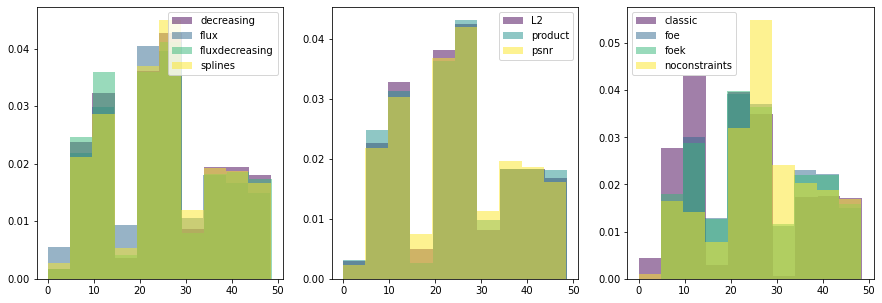

In [158]:
arch = np.unique(df.architecture)
loss = np.unique(df.loss)
types = np.unique(df.type)

imgs = ['house','peppers','barbara','boats']

plt.figure(figsize=(15,5))
plt.subplot(131)
colors = cm.viridis(np.linspace(0,1,len(arch)))
for j,i in enumerate(arch):
    dg = df[df.architecture == i]
    data = dg[imgs].values.flatten()
    plt.hist(data,color=colors[j],range=(0,np.amax(data)),alpha=0.5,label=i,density=True)

plt.legend()
    
plt.subplot(132)
colors = cm.viridis(np.linspace(0,1,len(loss)))
for j,i in enumerate(loss):
    dg = df[df.loss == i]
    data = dg[imgs].values.flatten()
    plt.hist(data,color=colors[j],range=(0,np.amax(data)),alpha=0.5,label=i,density=True)
    
plt.legend()

plt.subplot(133)
colors = cm.viridis(np.linspace(0,1,len(types)))
for j,i in enumerate(types):
    dg = df[df.type == i]
    data = dg[imgs].values.flatten()
    plt.hist(data,color=colors[j],range=(0,np.amax(data)),alpha=0.5,label=i,density=True)
    
plt.legend()
plt.show()

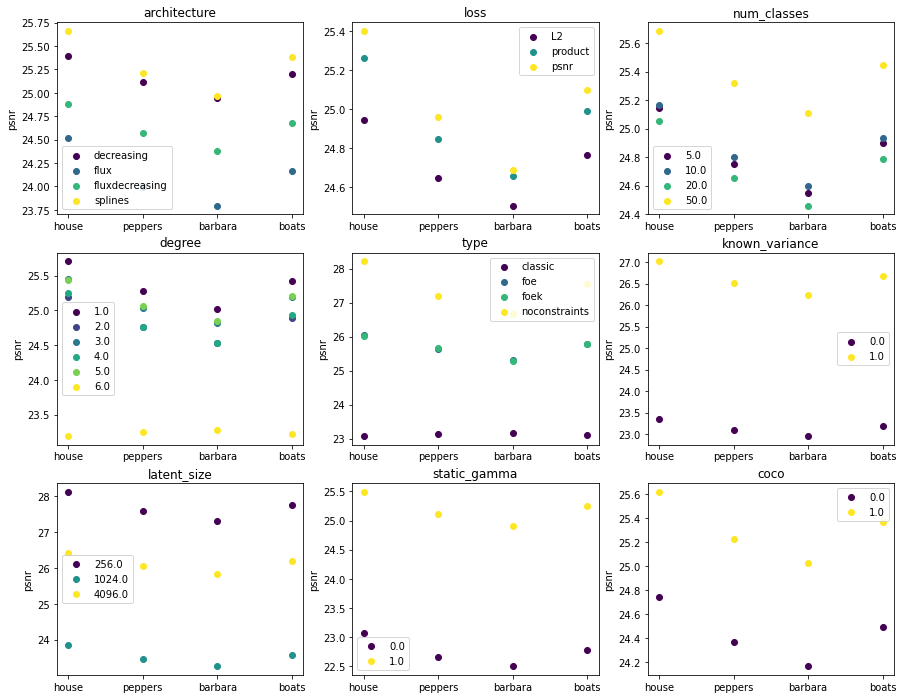

In [159]:
keys = ['architecture','loss','num_classes','degree','type','known_variance','latent_size','static_gamma','coco']
fig,axs = plt.subplots(ncols=3,nrows=3,figsize=(15,12))

for k,key in enumerate(keys):
    X = df.groupby(key).mean().reset_index()[[key]+imgs].values.T
    x,y = X[0],X[1:].T
    colors = cm.viridis(np.linspace(0,1,len(y)))
    for i in range(len(y)):
        axs[k//3,k%3].scatter(imgs,y[i],color=colors[i],label=x[i])
    axs[k//3,k%3].legend()
    axs[k//3,k%3].set_title(key)
    axs[k//3,k%3].set_ylabel('psnr')
    
plt.tight_layout

plt.show()

In [160]:
psnr_lit = np.array([[ 47.86, 47.69, 48.32, 47.81],
[ 42.92, 42.28, 44.01, 42.96],
[ 37.19, 36.27, 38.23, 37.63],
[ 32.83, 33.05, 35.06, 34.28],
[ 30.22, 31.22, 33.48, 32.03],
[ 28.32, 29.85, 32.17, 30.58],
[ 27.04, 28.72, 31.11, 29.20],
[ 23.15, 24.53, 26.74, 24.52],
[ 21.36, 22.48, 24.13, 21.68],
[ 19.77, 20.80, 21.66, 19.60]])

barbara,boats,house,peppers = psnr_lit.T

psnr_lit = np.array([house,peppers,barbara,boats])

variances = np.unique(df.variance.values)
vsFoe = []

for i in df[['variance','house','peppers','barbara','boats']].values:
    a = np.where(i[0]==variances)[0][0]
    vsFoe.append(i[1:]-psnr_lit.T[a])

    
vsFoe = np.array(vsFoe)

df['foe_house'] = vsFoe.T[0]
df['foe_peppers'] = vsFoe.T[1]
df['foe_barbara'] = vsFoe.T[2]
df['foe_boats'] = vsFoe.T[3]

flux product 10 1 noconstraints 1 1024 1 0
splines product 20 5 noconstraints 1 1024 1 0
flux psnr 10 4 noconstraints 1 4096 1 1
flux product 10 1 noconstraints 1 1024 1 0


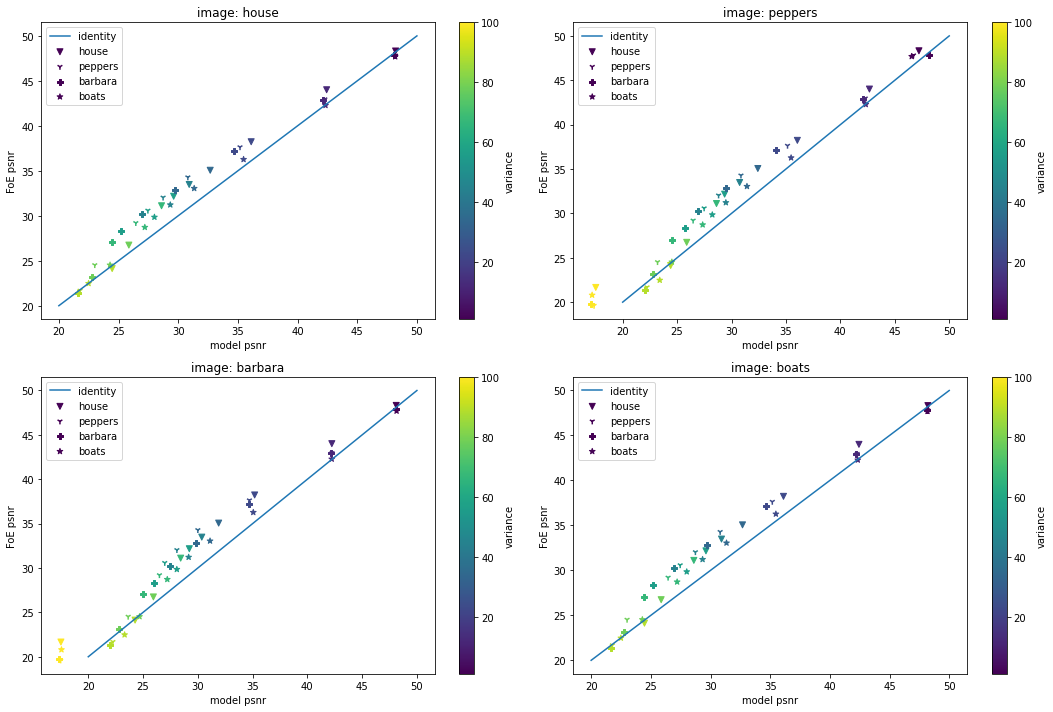

In [172]:
dg = df.groupby(keys).min().reset_index()
#vals = dg[imgs].values.T
vals = dg[['foe_house','foe_peppers','foe_barbara','foe_boats']].values.T

markers = ['v','1','P','*']

V = []

colors = cm.viridis(np.linspace(0,1,len(variances)))
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,10))
norm = mpl.colors.Normalize(vmin=np.amin(variances),vmax=np.amax(variances))
mappable = cm.ScalarMappable(norm)

for u,v in enumerate(np.argmax(vals,axis=1)):

    arch,loss,num_classes,degree,typee,known_variance,latent_size,static_gamma,coco = dg.iloc[v].values[:len(keys)]
    #arch,loss,num_classes,degree,typee,known_variance,latent_size = dg.iloc[v].values[:7]

    print(arch,loss,num_classes,degree,typee,known_variance,latent_size,static_gamma,coco)
    dh = df[(df.architecture==arch)&(df.loss==loss)&(df.num_classes==num_classes)&(df.degree==degree)&(df.type==typee)&(df.known_variance==known_variance)&(df.latent_size==latent_size)&(df.static_gamma==static_gamma)&(df.coco==coco)]
    #dh = df[(df.architecture==arch)&(df.loss==loss)&(df.num_classes==num_classes)&(df.degree==degree)&(df.type==typee)&(df.known_variance==known_variance)&(df.latent_size==latent_size)]
    psnr_model = dh[imgs].values.T
    model_var = dh.variance.values
    
    for i in range(len(imgs)):
        vec = [psnr_lit[i][j] for j in range(len(psnr_lit[i])) if variances[j] in model_var]
        c = [colors[j] for j in range(len(psnr_lit[i])) if variances[j] in model_var]
        
        im =  axs[u//2,u%2].scatter(psnr_model[i],vec,color=c,label=imgs[i],marker=markers[i])
        

    axs[u//2,u%2].plot([20,50],[20,50],label='identity')
    axs[u//2,u%2].legend()
    axs[u//2,u%2].set_xlabel('model psnr')
    axs[u//2,u%2].set_ylabel('FoE psnr')
    axs[u//2,u%2].set_title(f'image: {imgs[u]}')
    plt.colorbar(mappable=mappable,ax=axs[u//2,u%2],label='variance')
    
    
plt.tight_layout()
plt.show()

In [173]:
keys = ['architecture','loss','num_classes','degree','type','known_variance','latent_size','static_gamma','coco']
taken = []

while len(taken) < len(keys):
    std = []
    for key in np.setdiff1d(keys,taken):
        key1 = np.concatenate(([key],taken))
        dg = df.groupby(list(np.concatenate([key1,['variance']]))).std().reset_index()
        std.append(np.std(np.mean(dg.groupby(key).mean().reset_index()[imgs].values,axis=1)))
    taken.append(np.setdiff1d(keys,taken)[np.argmax(std)])
    
taken

['latent_size',
 'static_gamma',
 'type',
 'known_variance',
 'architecture',
 'degree',
 'coco',
 'num_classes',
 'loss']

In [187]:
it_lim = 10
factor = 1
model_256 = get_model(arch,it_lim=it_lim,image_size=image_size,num_classes = num_classes,
                                                                  second=True,degree1=degree,factor=factor,typee=typee,
                                                                 known_variance = known_variance,latent_size=latent_size,
                                                                 static_gamma=static_gamma)

model_256.load_weights(f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{latent_size}_{typee}_{int(known_variance)}_{int(static_gamma)}_{int(coco)}_0")

model_512 = get_model(arch,it_lim=it_lim,image_size=(512,512),num_classes = num_classes,
                                                                  second=True,degree1=degree,factor=factor,typee=typee,
                                                                 known_variance = known_variance,latent_size=latent_size,
                                                                 static_gamma=static_gamma)

model_512.load_weights(f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{latent_size}_{typee}_{int(known_variance)}_{int(static_gamma)}_{int(coco)}_0")


In [188]:
variance = [1,2,5,10,15,20,25,50,75,100]
set12_256 = ['../../images/Set12/02.png','../../images/Set12/03.png']
set12_512 = ['../../images/Set12/09.png','../../images/Set12/10.png']


set12_256 = np.array([[open_frame(im,var=v,CROP=256) for v in variance] for im in set12_256])
ys_256,noisy_256 = set12_256[:,:,0],set12_256[:,:,1]
ys_256,noisy_256 = np.concatenate(ys_256),np.concatenate(noisy_256)
ys_256,noisy_256 = np.expand_dims(ys_256,axis=-1),np.expand_dims(noisy_256,axis=-1)

set12_512 = np.array([[open_frame(im,var=v,CROP=512) for v in variance] for im in set12_512])
ys_512,noisy_512 = set12_512[:,:,0],set12_512[:,:,1]
ys_512,noisy_512 = np.concatenate(ys_512),np.concatenate(noisy_512)
ys_512,noisy_512 = np.expand_dims(ys_512,axis=-1),np.expand_dims(noisy_512,axis=-1)


In [199]:
varss = np.expand_dims(np.concatenate([variance,variance]),axis=-1)
varss = np.asarray(varss,dtype='float')

p_256 = model_256([noisy_256,varss])
p_512 = model_512([noisy_512,varss])

psnr_256 = tf.image.psnr(ys_256,p_256,255).numpy()
psnr_512 = tf.image.psnr(ys_512,p_512,255).numpy()

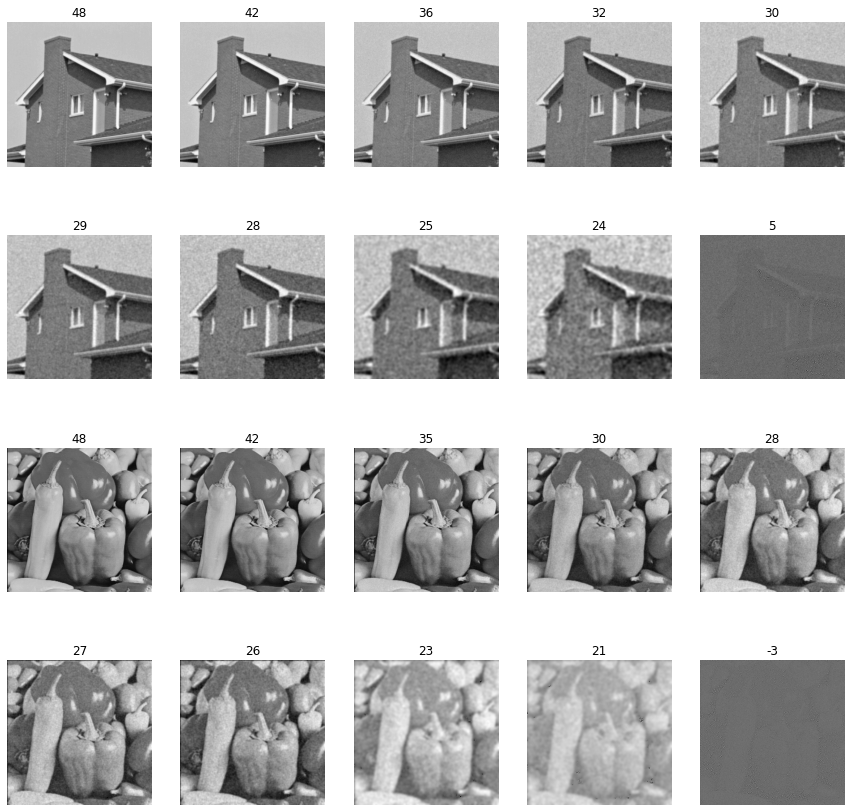

In [201]:
fig,axs = plt.subplots(nrows=4,ncols=5,figsize=(15,15))

for i in range(20):
    axs[i//5,i%5].imshow(p_256[i],cmap='gray')
    axs[i//5,i%5].axis('off')
    axs[i//5,i%5].set_title(int(psnr_256[i]))

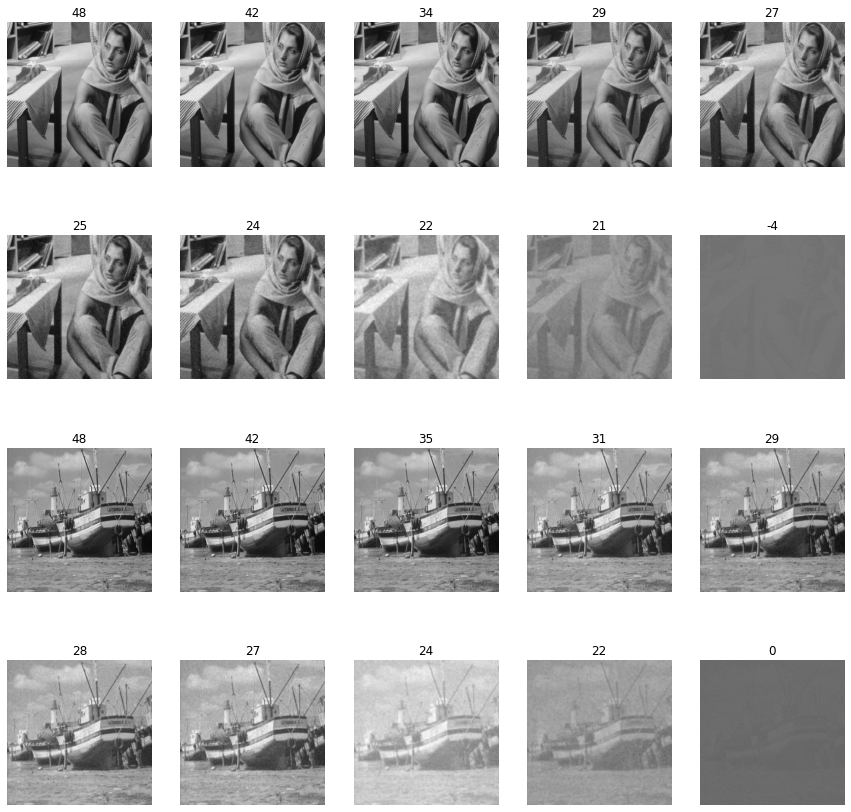

In [204]:
fig,axs = plt.subplots(nrows=4,ncols=5,figsize=(15,15))

for i in range(20):
    axs[i//5,i%5].imshow(p_512[i],cmap='gray')
    axs[i//5,i%5].axis('off')
    axs[i//5,i%5].set_title(int(psnr_512[i]))

In [214]:
model_256.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_707 (Lambda)            (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 conv2d_42 (Conv2D)             (None, 128, 128, 32  320         ['lambda_707[0][0]']             
                                )                                                                 
                                                                                           

                                                                                                  
 activation_84 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 separable_conv2d_68 (Separable  (None, 32, 32, 64)  4736        ['activation_84[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_84 (BatchN  (None, 32, 32, 64)  256         ['separable_conv2d_68[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 16, 16, 64)  0           ['batch_normalization_84[0][0]'] 
 )        

 bda)                                                                                             
                                                                                                  
 lambda_711 (Lambda)            (None, 10, 1)        0           ['reshape_14[0][0]']             
                                                                                                  
 tf.compat.v1.shape_14 (TFOpLam  (3,)                0           ['reshape_14[0][0]']             
 bda)                                                                                             
                                                                                                  
 multiply_447 (Multiply)        (None, 10, 1)        0           ['lambda_719[0][0]',             
                                                                  'lambda_718[0][0]']             
                                                                                                  
 tf.__oper

                                                                                                  
 lambda_722 (Lambda)            (None, None)         0           ['concatenate_239[0][0]']        
                                                                                                  
 lambda_717 (Lambda)            (None, 1)            0           ['dense_30[0][0]']               
                                                                                                  
 tf.math.multiply_15 (TFOpLambd  (None, 10, 1)       0           ['tf.math.cumsum_15[0][0]']      
 a)                                                                                               
                                                                                                  
 tf.ones_like_170 (TFOpLambda)  (None, 10, 1)        0           ['reshape_15[0][0]']             
                                                                                                  
 lambda_71

                                                                                                  
 multiply_446 (Multiply)        (None,)              0           ['lambda_715[0][0]',             
                                                                  'lambda_716[0][0]']             
                                                                                                  
 lambda_725 (Lambda)            (None, 1)            0           ['multiply_453[0][0]']           
                                                                                                  
 add_238 (Add)                  (None, None, 1)      0           ['tf.expand_dims_224[0][0]',     
                                                                  'multiply_446[0][0]']           
                                                                                                  
 add_243 (Add)                  (None, None, 1)      0           ['tf.expand_dims_225[0][0]',     
          

                                ))                                                                
                                                                                                  
 tf.zeros_like_140 (TFOpLambda)  (None, 256, 256, 1)  0          ['input[0][0]']                  
                                                                                                  
 tf.expand_dims_228 (TFOpLambda  (None, 1, 256, 1)   0           ['tf.__operators__.getitem_157[0]
 )                                                               [0]']                            
                                                                                                  
 multiply_457 (Multiply)        (None, 256, 256, 1)  0           ['tf.expand_dims_226[0][0]',     
                                                                  'lambda_732[0][0]']             
                                                                                                  
 tf.__oper

 )                                                                                                
                                                                                                  
 lambda_740 (Lambda)            ((None, 256, 256, 1  0           ['add_245[0][0]']                
                                ),                                                                
                                 (None, 256, 256, 1                                               
                                ))                                                                
                                                                                                  
 tf.zeros_like_142 (TFOpLambda)  (None, 256, 256, 1)  0          ['add_245[0][0]']                
                                                                                                  
 tf.expand_dims_231 (TFOpLambda  (None, 1, 256, 1)   0           ['tf.__operators__.getitem_159[0]
 )        

                                                                                                  
 tf.__operators__.getitem_161 (  (None, 256, 1)      0           ['tf.zeros_like_145[0][0]']      
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.expand_dims_232 (TFOpLambda  (None, 256, 256, 1)  0          ['g_2[0][0]']                    
 )                                                                                                
                                                                                                  
 lambda_748 (Lambda)            ((None, 256, 256, 1  0           ['add_247[0][0]']                
                                ),                                                                
                                 (None, 256, 256, 1                                               
          

                                )                                 'tf.cast_73[0][0]']             
                                                                                                  
 tf.zeros_like_147 (TFOpLambda)  (None, 256, 256, 1)  0          ['input[0][0]']                  
                                                                                                  
 g_3 (Lambda)                   (None, 256, 256)     0           ['multiply_470[0][0]']           
                                                                                                  
 tf.__operators__.getitem_163 (  (None, 256, 1)      0           ['tf.zeros_like_147[0][0]']      
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.expand_dims_235 (TFOpLambda  (None, 256, 256, 1)  0          ['g_3[0][0]']                    
 )        

                                                                                                  
 tf.cast_74 (TFOpLambda)        (None, 256, 256, 20  0           ['tf.math.logical_and_74[0][0]'] 
                                )                                                                 
                                                                                                  
 multiply_475 (Multiply)        (None, 256, 256, 20  0           ['lambda_763[0][0]',             
                                )                                 'tf.cast_74[0][0]']             
                                                                                                  
 tf.zeros_like_149 (TFOpLambda)  (None, 256, 256, 1)  0          ['input[0][0]']                  
                                                                                                  
 g_4 (Lambda)                   (None, 256, 256)     0           ['multiply_475[0][0]']           
          

 tf.math.logical_and_75 (TFOpLa  (None, 256, 256, 20  0          ['tf.math.greater_equal_75[0][0]'
 mbda)                          )                                , 'tf.math.less_equal_75[0][0]'] 
                                                                                                  
 lambda_771 (Lambda)            (None, 256, 256, 20  0           ['multiply_479[0][0]']           
                                )                                                                 
                                                                                                  
 tf.cast_75 (TFOpLambda)        (None, 256, 256, 20  0           ['tf.math.logical_and_75[0][0]'] 
                                )                                                                 
                                                                                                  
 multiply_480 (Multiply)        (None, 256, 256, 20  0           ['lambda_771[0][0]',             
          

 bda)                           )                                                                 
                                                                                                  
 multiply_484 (Multiply)        (None, 256, 256, 20  0           ['lambda_727[0][0]',             
                                , 2)                              'lambda_778[0][0]']             
                                                                                                  
 tf.math.logical_and_76 (TFOpLa  (None, 256, 256, 20  0          ['tf.math.greater_equal_76[0][0]'
 mbda)                          )                                , 'tf.math.less_equal_76[0][0]'] 
                                                                                                  
 lambda_779 (Lambda)            (None, 256, 256, 20  0           ['multiply_484[0][0]']           
                                )                                                                 
          

                                                                                                  
 tf.math.greater_equal_77 (TFOp  (None, 256, 256, 20  0          ['lambda_784[0][0]']             
 Lambda)                        )                                                                 
                                                                                                  
 tf.math.less_equal_77 (TFOpLam  (None, 256, 256, 20  0          ['lambda_784[0][0]']             
 bda)                           )                                                                 
                                                                                                  
 multiply_489 (Multiply)        (None, 256, 256, 20  0           ['lambda_727[0][0]',             
                                , 2)                              'lambda_786[0][0]']             
                                                                                                  
 tf.math.l

 concatenate_266 (Concatenate)  (None, 256, 256, 2)  0           ['tf.ones_like_188[0][0]',       
                                                                  'lambda_793[0][0]']             
                                                                                                  
 lambda_794 (Lambda)            (None, 256, 256, 1,  0           ['concatenate_266[0][0]']        
                                 2)                                                               
                                                                                                  
 tf.math.greater_equal_78 (TFOp  (None, 256, 256, 20  0          ['lambda_792[0][0]']             
 Lambda)                        )                                                                 
                                                                                                  
 tf.math.less_equal_78 (TFOpLam  (None, 256, 256, 20  0          ['lambda_792[0][0]']             
 bda)     

                                                                                                  
 tf.ones_like_190 (TFOpLambda)  (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 lambda_801 (Lambda)            (None, 256, 256, 1)  0           ['lambda_800[0][0]']             
                                                                                                  
 concatenate_269 (Concatenate)  (None, 256, 256, 2)  0           ['tf.ones_like_190[0][0]',       
                                                                  'lambda_801[0][0]']             
                                                                                                  
 lambda_802 (Lambda)            (None, 256, 256, 1,  0           ['concatenate_269[0][0]']        
                                 2)                                                               
          

                                                                                                  
 add_263 (Add)                  (None, 256, 256, 1)  0           ['add_261[0][0]',                
                                                                  'multiply_503[0][0]']           
                                                                                                  
Total params: 334,235
Trainable params: 331,035
Non-trainable params: 3,200
__________________________________________________________________________________________________
